In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Device management for optimal learning rate
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
        
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return[to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for x in self.dl:
            yield to_device(x, device)
    def __len__(self):
        return len(self.dl)

In [3]:
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
valid_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train_set = datasets.CIFAR10(root='../data', train=True, download=True, transform=train_transform)
test_set = datasets.CIFAR10(root='../data', train=False, download=True, transform=valid_transform)
img_datasets = {'train': train_set, 'val': test_set}

dataloaders = {x: torch.utils.data.DataLoader(img_datasets[x], batch_size=64, shuffle=True, num_workers=2)for x in ['train', 'val']}
dataset_sizes = {x: len(img_datasets[x]) for x in ['train', 'val']}
class_names = img_datasets['train'].classes

Files already downloaded and verified
Files already downloaded and verified


In [4]:
device = get_default_device()
train_dl = DeviceDataLoader(dataloaders['train'], device)
valid_dl = DeviceDataLoader(dataloaders['val'], device)
dataloaders = {'train': train_dl, 'val': valid_dl}

In [5]:
def train_model(model, loss_fn, optimizer, scheduler, num_epochs=25):
        best_model_params_path = '../models/resnet18_best.pth'
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        for epoch in range(num_epochs):
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()
                running_loss = 0.0
                running_corrects = 0
                for inputs, labels in dataloaders[phase]:
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = loss_fn(outputs, labels)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]  
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
        return model

In [6]:
model= torchvision.models.resnet18(weights = 'IMAGENET1K_V1')
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
sch = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [9]:
model = train_model(model, loss_fn, opt, sch, num_epochs=15)

Epoch 0/14
----------
train Loss: 1.1333 Acc: 0.6035
val Loss: 0.7474 Acc: 0.7442

Epoch 1/14
----------
train Loss: 1.1289 Acc: 0.6052
val Loss: 0.7381 Acc: 0.7484

Epoch 2/14
----------
train Loss: 1.1181 Acc: 0.6115
val Loss: 0.7337 Acc: 0.7544

Epoch 3/14
----------
train Loss: 1.1143 Acc: 0.6130
val Loss: 0.7244 Acc: 0.7535

Epoch 4/14
----------
train Loss: 1.1027 Acc: 0.6159
val Loss: 0.7350 Acc: 0.7528

Epoch 5/14
----------
train Loss: 1.1155 Acc: 0.6083
val Loss: 0.7317 Acc: 0.7518

Epoch 6/14
----------
train Loss: 1.1094 Acc: 0.6121
val Loss: 0.7321 Acc: 0.7524

Epoch 7/14
----------
train Loss: 1.1117 Acc: 0.6119
val Loss: 0.7291 Acc: 0.7534

Epoch 8/14
----------
train Loss: 1.1193 Acc: 0.6096
val Loss: 0.7287 Acc: 0.7523

Epoch 9/14
----------
train Loss: 1.1069 Acc: 0.6122
val Loss: 0.7331 Acc: 0.7521

Epoch 10/14
----------
train Loss: 1.1155 Acc: 0.6081
val Loss: 0.7301 Acc: 0.7530

Epoch 11/14
----------
train Loss: 1.1026 Acc: 0.6118
val Loss: 0.7312 Acc: 0.7515

Ep

              precision    recall  f1-score   support

    airplane       0.71      0.81      0.76      1000
  automobile       0.81      0.88      0.84      1000
        bird       0.77      0.61      0.68      1000
         cat       0.63      0.61      0.62      1000
        deer       0.69      0.77      0.72      1000
         dog       0.78      0.70      0.73      1000
        frog       0.77      0.81      0.79      1000
       horse       0.80      0.72      0.76      1000
        ship       0.78      0.81      0.80      1000
       truck       0.83      0.82      0.83      1000

    accuracy                           0.75     10000
   macro avg       0.76      0.75      0.75     10000
weighted avg       0.76      0.75      0.75     10000



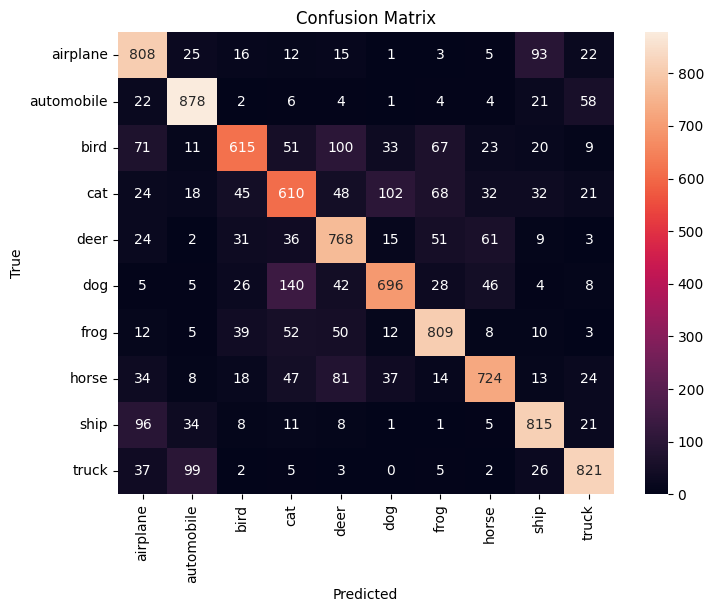

In [13]:

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in valid_dl:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy()) 

# Print classification report
print(classification_report(y_true, y_pred, target_names=test_set.classes))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=test_set.classes, yticklabels=test_set.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
